# Prescription

In [74]:
using CSV, DataFrames, Random, Gurobi, JuMP, Statistics, ScikitLearn, Plots

In [17]:
# Load the data
df_preds = CSV.read("predictions.csv", DataFrame)
df_capacity = CSV.read("capacity.csv", DataFrame)
df_emissions = CSV.read("emissions.csv", DataFrame)
df_cost = CSV.read("production_costs.csv", DataFrame)
df_train = CSV.read("demand_train.csv", DataFrame)
df_test = CSV.read("demand_test.csv", DataFrame);

In [25]:
# Create X and y
X_train = select(df_train, Not([:Column1, :date, :demand]))
y_train = select(df_train, :demand)
X_test = select(df_test, Not([:Column1, :date, :demand]))
y_test = select(df_test, :demand)
first(X_test, 5)

Row,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day_N,school_day_Y,holiday_N,holiday_Y,weekend_0,weekend_1
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Bool,Bool,Bool,Bool,Bool
1,47.3506,1.07629e5,47.3506,0.0,0.0,0.0,11.4,16.4,22.2,2.0,false,true,true,false,true,false
2,59.0447,1.08418e5,59.0447,0.0,0.0,0.0,8.6,24.8,31.0,0.0,false,true,true,false,true,false
3,70.2026,1.12736e5,70.2026,0.0,0.0,0.0,11.4,21.1,30.7,0.0,false,true,true,false,true,false
4,79.6057,1.148e5,79.6057,0.0,0.0,0.0,11.9,19.7,21.9,0.0,false,true,true,false,true,false
5,51.0587,93762.8,55.6113,5196.73,-31.0821,0.0625,10.3,18.4,26.7,8.0,false,true,true,false,false,true


In [6]:
# Define iterators
T = size(X_test, 1);
I = size(df_capacity, 1);

In [57]:
P = df_capacity[!,:capacity_mWh] * 12 # 1 = Coal, 2 = Petroleum, 3 = Wind&Solar
e = df_emissions[!,:Pounds_per_mWh] # Carbon emissions for producing 1 megawatt of energy
E = 3376998652.05 # Maximum carbon emissions per day
c = df_cost[!,:AUSD_per_mWh] # Cost of production
s = 30.34 # Selling price per megawatt

30.34

## General formulation

In [24]:
alpha = 1000 # Parameter to control the price of buying energy from an outside source

model = Model(Gurobi.Optimizer)

@variable(model, z[i=1:I,t=1:T])

@constraint(model, emissions_constraint[t=1:T], (sum(z[i,t] * e[i] for i=1:I)) <= E)
@constraint(model, production_constraint[i=1:I, t=1:T], z[i,t] <=  P[i])

#@objective(model, Min, sum(sum(z[i,t] * c[i] for i=1:I) - s[t] * y[t] + alpha * max(0, sum(y[t] - z[i,t] for i=1:I)) for t=1:T)) 

# Auxiliary variable for modeling max operator in objective function
@variable(model, u[t=1:T] >= 0) 
for t in 1:T
    @constraint(model, u[t] >= y[t] - sum(z[i, t] for i=1:I))
    @constraint(model, u[t] >= 0)
end

@objective(model, Min, sum(sum(z[i, t] * c[i] for i=1:I) - s * y[t] + alpha * u[t] for t=1:T))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22


LoadError: UndefVarError: `y` not defined

## Method 1 - SAA

In [29]:
# Get average demand over training set
average_y = mean(y_train[!,:demand]);

In [58]:
alpha = 1000

model = Model(Gurobi.Optimizer);

@variable(model, z[i=1:I,t=1:T] >= 0)

@constraint(model, emissions_constraint[t=1:T], (sum(z[i,t] * e[i] for i=1:I)) <= E)
@constraint(model, production_constraint[i=1:I, t=1:T], z[i,t] <=  P[i])

#@objective(model, Min, sum(sum(z[i,t] * c[i] for i=1:I) - s[t] * y[t] + alpha * max(0, sum(y[t] - z[i,t] for i=1:I)) for t=1:T)) 

# Auxiliary variable for modeling max operator in objective function
@variable(model, u[t=1:T] >= 0) 
for t in 1:T
    @constraint(model, u[t] >= average_y - sum(z[i, t] for i=1:I))
    @constraint(model, u[t] >= 0)
end

@objective(model, Min, sum(sum(z[i, t] * c[i] for i=1:I) - s * average_y + alpha * u[t] for t=1:T))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22


138.84 z[1,1] + 131.84 z[2,1] + 84.84 z[3,1] + 1000 u[1] + 138.84 z[1,2] + 131.84 z[2,2] + 84.84 z[3,2] + 1000 u[2] + 138.84 z[1,3] + 131.84 z[2,3] + 84.84 z[3,3] + 1000 u[3] + 138.84 z[1,4] + 131.84 z[2,4] + 84.84 z[3,4] + 1000 u[4] + 138.84 z[1,5] + 131.84 z[2,5] + 84.84 z[3,5] + 1000 u[5] + 138.84 z[1,6] + 131.84 z[2,6] + 84.84 z[3,6] + 1000 u[6] + 138.84 z[1,7] + 131.84 z[2,7] + 84.84 z[3,7] + 1000 u[7] + 138.84 z[1,8] + 131.84 z[2,8] + 84.84 z[3,8] + 1000 u[8] + 138.84 z[1,9] + 131.84 z[2,9] + 84.84 z[3,9] + 1000 u[9] + 138.84 z[1,10] + 131.84 z[2,10] + 84.84 z[3,10] + 1000 u[10] + 138.84 z[1,11] + 131.84 z[2,11] + 84.84 z[3,11] + 1000 u[11] + 138.84 z[1,12] + 131.84 z[2,12] + 84.84 z[3,12] + 1000 u[12] + 138.84 z[1,13] + 131.84 z[2,13] + 84.84 z[3,13] + 1000 u[13] + 138.84 z[1,14] + 131.84 z[2,14] + 84.84 z[3,14] + 1000 u[14] + 138.84 z[1,15] + 131.84 z[2,15] + 84.84 z[3,15] + 1000 u[15] + 138.84 z[1,16] + 131.84 z[2,16] + 84.84 z[3,16] + 1000 u[16] + 138.84 z[1,17] + 131.84 z[2,

In [59]:
set_optimizer_attribute(model, "TimeLimit", 60.0);
optimize!(model);

Set parameter TimeLimit to value 60
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1896 rows, 1264 columns and 3476 nonzeros
Model fingerprint: 0xcbb74835
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [8e+01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+04, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1580 rows and 0 columns
Presolve time: 0.00s
Presolved: 316 rows, 1264 columns, 1264 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1570435e+09   1.508541e+04   0.000000e+00      0s
       1    3.0479559e+09   0.000000e+00   0.000000e+00      0s

Use crossover to convert LP symmetric solution to basic solution...
C

In [80]:
prescriptions = JuMP.value.(z)

3×316 Matrix{Float64}:
 33527.3  33527.3  33527.3  33527.3  …  33527.3  33527.3  33527.3  33527.3
 26760.0  26760.0  26760.0  26760.0     26760.0  26760.0  26760.0  26760.0
 60396.0  60396.0  60396.0  60396.0     60396.0  60396.0  60396.0  60396.0

In [84]:
function prescription_vs_reality(z, y_test)
    """ Function to evaluate the quality of our prescriptions. 
    Assume we produce Z quantity of energy, would we able to meet all predicted demand (i.e. were the constraints restrictive/tight ?)
    Assume we produce Z quantity of energy, would we able to meet all true demand (i.e. in real life how far are we from satisfying demand ?)
    """
    res = []
    for t in 1:T 
        production_t = 0 # Total energy production at day t
        for i in 1:I
            production_t += z[i,t]
        end
        diff_pred = average_y - production_t # How much demand you were not able to meet (if demand = y_pred)
        diff_true = y_test[t,:demand] - production_t # How much demand you were not able to meet (if demand = y_true)
        push!(res, (produced=production_t, y_pred=average_y, not_met_pred=diff_pred, y_true=y_test[t,:demand],not_met_true=diff_true))
    end
    return res
end;

function carbon_emissions(z)
    """ Function to compute the total carbon emissions of our prescriptions, and daily carbon emissions."""
    total_emissions = []
    for t in 1:T 
        emissions_t = 0 # Total energy production at day t
        for i in 1:I
            emissions_t += z[i,t] * e[i]
        end
        push!(total_emissions, emissions_t)
    end 
    return sum(total_emissions), total_emissions
end;

In [89]:
evaluate_results = prescription_vs_reality(prescriptions, y_test);
total_prescription_emissions, prescription_emissions = carbon_emissions(prescriptions);

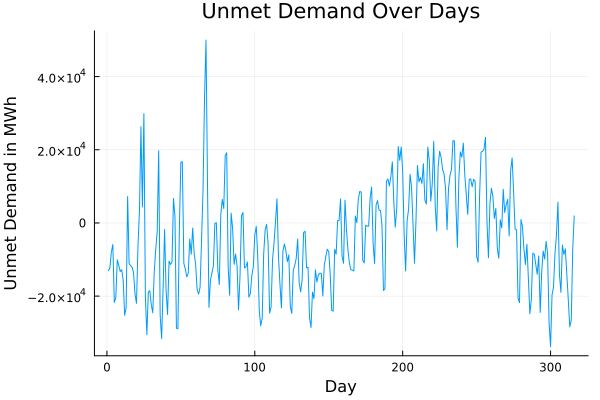

In [83]:
produced = [res.produced for res in evaluate_results]
not_met_true = [res.not_met_true for res in evaluate_results]
days = 1:T

# Plot for 'not_met_true'
plot(days, not_met_true, title = "Unmet Demand Over Days", xlabel = "Day", ylabel = "Unmet Demand in MWh", legend = false)

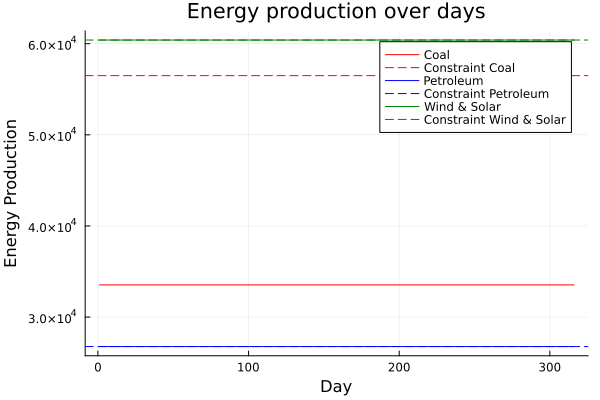

In [111]:
# Plot the production of the different types of energy over the days
coal_production = prescriptions[1, :]
petroleum_production = prescriptions[2, :]
wind_solar_production = prescriptions[3, :]
days = 1:T
plot(days, coal_production, label = "Coal", color = :red, title = "Energy production over days", xlabel = "Day", ylabel = "Energy Production", legend = :topright)
hline!([P[1]], color = :red, linestyle = :dash, label = "Constraint Coal")

plot!(days, petroleum_production, label = "Petroleum", color = :blue)
hline!([P[2]], color = :blue, linestyle = :dash, label = "Constraint Petroleum")

plot!(days, wind_solar_production, label = "Wind & Solar", color = :green)
hline!([P[3]], color = :green, linestyle = :dash, label = "Constraint Wind & Solar")


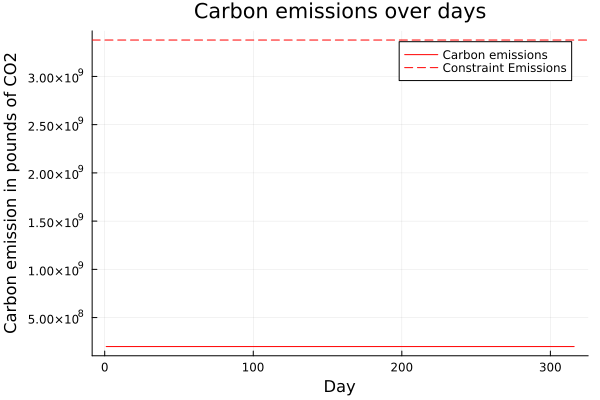

In [109]:
days = 1:T
plot(days, prescription_emissions, label = "Carbon emissions", color = :red, title = "Carbon emissions over days", xlabel = "Day", ylabel = "Carbon emission in pounds of CO2", legend = :topright)
# Set ylim=(0, 1.1e9) for nicer plot
hline!([E], color = :red, linestyle = :dash, label = "Constraint Emissions")

### Dummy model for baseline
Everyday, forecast demand (in this case using average y of the train set), then decide to produce everything you can from cheapest source
(in this case petroleum) until demand is met OR until you saturate the production capacity constraint for petroleum, then if there is still demand produce from second cheapest source (in this case coal), etc. 